<a href="https://colab.research.google.com/github/AnuBaluguri/DeepFake-Detection/blob/main/FinalCNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from tensorflow.keras.utils import to_categorical


In [ ]:
# Load preprocessed data from Google Drive
X_train = np.load('/content/drive/MyDrive/Deepfake Detection Data/X_train.npy')
X_test = np.load('/content/drive/MyDrive/Deepfake Detection Data/X_test.npy')
y_train = np.load('/content/drive/MyDrive/Deepfake Detection Data/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Deepfake Detection Data/y_test.npy')


In [ ]:
# Define parameters
sequence_length = 30  # Increased sequence length
image_size = 128  # Image dimensions (width and height)


In [ ]:
# Precompute CNN features using Xception
def extract_features(data):
    feature_extractor = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(image_size, image_size, 3))
    precomputed_features = []
    for frame in data:
        frame = tf.image.resize(frame, (image_size, image_size))  # Resize to match Xception input
        frame = np.expand_dims(frame, axis=0)  # Add batch dimension
        features = feature_extractor.predict(frame)
        precomputed_features.append(features.flatten())
    return np.array(precomputed_features)


In [ ]:
# Extract features for all frames
print("Extracting features for training data...")
X_train_features = extract_features(X_train)
print("Extracting features for test data...")
X_test_features = extract_features(X_test)


Extracting features for training data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/

In [ ]:
# Data augmentation
print("Augmenting training data...")
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
augmented_X_train = []
augmented_y_train = []


Augmenting training data...


In [ ]:
for i in range(len(X_train)):
    for _ in range(5):  # Generate 5 augmentations per frame
        augmented_frame = datagen.random_transform(X_train[i])
        augmented_X_train.append(augmented_frame)
        augmented_y_train.append(y_train[i])


In [ ]:
X_train = np.array(augmented_X_train)
y_train = np.array(augmented_y_train)


In [ ]:
# Group features into sequences
def create_sequences(features, labels, seq_len):
    sequences = []
    sequence_labels = []
    for i in range(0, len(features) - seq_len + 1, seq_len):
        sequences.append(features[i:i + seq_len])
        sequence_labels.append(labels[i + seq_len - 1])  # Label based on last frame in sequence
    return np.array(sequences), np.array(sequence_labels)


In [ ]:
print("Grouping training features into sequences...")
X_train_seq, y_train_seq = create_sequences(X_train_features, y_train, sequence_length)
print("Grouping test features into sequences...")
X_test_seq, y_test_seq = create_sequences(X_test_features, y_test, sequence_length)


Grouping training features into sequences...
Grouping test features into sequences...


In [ ]:
# Check class distribution
print("Class Distribution in y_train_seq:", Counter(y_train_seq.flatten() if isinstance(y_train_seq, np.ndarray) else y_train_seq))


Class Distribution in y_train_seq: Counter({0.0: 8, 1.0: 8})


In [ ]:
# Balance classes using oversampling
ros = RandomOverSampler(random_state=42)
X_train_seq_balanced, y_train_seq_balanced = ros.fit_resample(
    X_train_seq.reshape(X_train_seq.shape[0], -1), y_train_seq.flatten()
)
X_train_seq_balanced = X_train_seq_balanced.reshape(-1, sequence_length, 2048)
y_train_seq_balanced = to_categorical(y_train_seq_balanced, num_classes=2)



In [ ]:
# Ensure consistent shapes before splitting
print("Shape of X_train_seq_balanced before splitting:", X_train_seq_balanced.shape)
print("Shape of y_train_seq_balanced before splitting:", y_train_seq_balanced.shape)
if X_train_seq_balanced.shape[0] != len(y_train_seq_balanced):
    min_length = min(X_train_seq_balanced.shape[0], len(y_train_seq_balanced))
    X_train_seq_balanced = X_train_seq_balanced[:min_length]
    y_train_seq_balanced = y_train_seq_balanced[:min_length]



Shape of X_train_seq_balanced before splitting: (8, 30, 2048)
Shape of y_train_seq_balanced before splitting: (16, 2)


In [ ]:
# One-hot encode the test labels
y_test_seq = to_categorical(y_test_seq, num_classes=2)


In [ ]:
# Split training data into training and validation sets
X_train_seq_balanced, X_val_seq, y_train_seq_balanced, y_val_seq = train_test_split(
    X_train_seq_balanced, y_train_seq_balanced, test_size=0.2, random_state=42
)


In [ ]:
# Ensure consistency for test set
test_min_length = min(len(X_test_seq), len(y_test_seq))
X_test_seq = X_test_seq[:test_min_length]
y_test_seq = y_test_seq[:test_min_length]


In [ ]:
# Define Bi-LSTM model
input_layer = Input(shape=(sequence_length, 2048))  # 2048 is the output size of Xception's pooling layer
x = Bidirectional(LSTM(256, activation='tanh', return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(input_layer)
x = LSTM(256, activation='tanh', return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)
x = Dropout(0.5)(x)  # Increased dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Increased dropout for regularization
output_layer = Dense(2, activation='softmax')(x)


In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)


In [ ]:
# Compile the model with weighted loss to handle class imbalance
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=loss, metrics=['accuracy'])


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Deepfake Detection Data/best_cnn_lstm_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               mode='max',
                               verbose=1)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [ ]:
# Train the model
history = model.fit(
    X_train_seq_balanced, y_train_seq_balanced,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=4,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.1667 - loss: 0.8280 
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /content/drive/MyDrive/Deepfake Detection Data/best_cnn_lstm_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.2222 - loss: 0.7989 - val_accuracy: 0.0000e+00 - val_loss: 0.8473 - learning_rate: 1.0000e-04
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7083 - loss: 0.6171
Epoch 2: val_accuracy did not improve from 0.00000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - accuracy: 0.6944 - loss: 0.6250 - val_accuracy: 0.0000e+00 - val_loss: 0.9670 - learning_rate: 1.0000e-04
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.7083 - loss: 0.6693
Epoch 3: val_accuracy did not improve from 0.00000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 857ms/step - accuracy: 0.6944 - loss: 0.6680 - val_accuracy: 0.0000e+00 - val_loss: 0.8582 - learning_rate: 1.0000e-04
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9

In [ ]:
# Debugging shapes before evaluation
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)


Shape of X_test_seq: (2, 30, 2048)
Shape of y_test_seq: (2, 2, 2)


In [ ]:
# Reshape y_test_seq if it has extra dimensions
if len(y_test_seq.shape) > 2:
    y_test_seq = y_test_seq.reshape(-1, y_test_seq.shape[-1])

In [ ]:
# Ensure matching lengths
test_min_length = min(len(X_test_seq), len(y_test_seq))
X_test_seq = X_test_seq[:test_min_length]
y_test_seq = y_test_seq[:test_min_length]

# Debugging after fixes
print("Shape of X_test_seq after trimming:", X_test_seq.shape)
print("Shape of y_test_seq after reshaping and trimming:", y_test_seq.shape)

Shape of X_test_seq after trimming: (2, 30, 2048)
Shape of y_test_seq after reshaping and trimming: (2, 2)


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5000 - loss: 0.7144
Test Accuracy: 50.00%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted classes
y_true = np.argmax(y_test_seq, axis=1)      # True classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


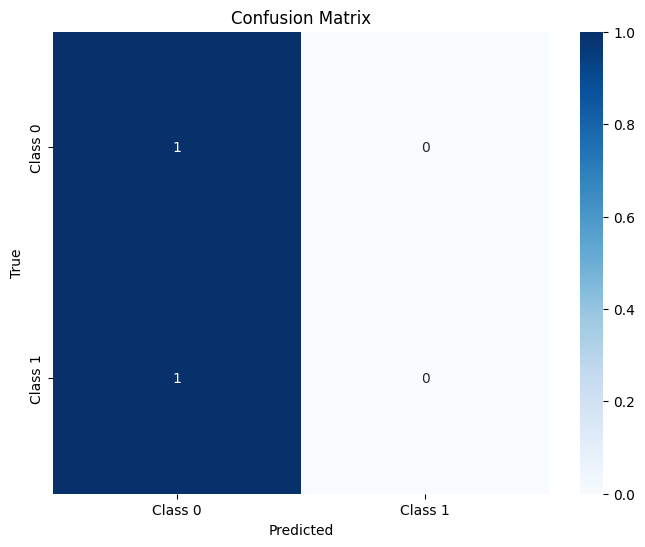

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

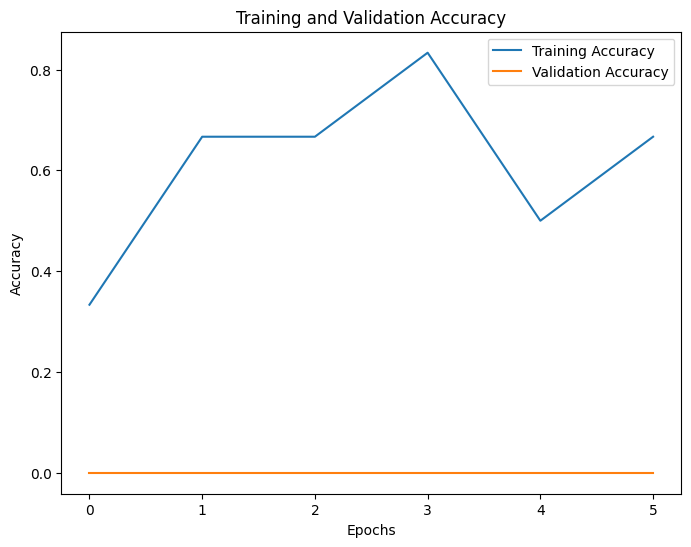

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



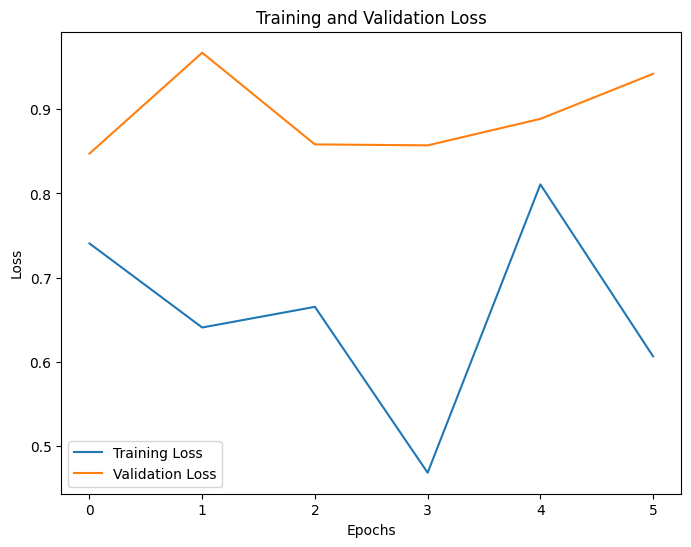

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
